In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import GaussianMixture
import numpy as np


In [2]:
import os
print(os.getcwd())


/Users/blambright/Downloads/Big Data Analytics/wedding-song-recommendations/modeling


In [3]:
# creating spark app
spark = SparkSession.builder.appName("Creating_Clustering_Model").getOrCreate()

#reading in the CSV file 
df = spark.read.csv('numpy_array_for_modeling.csv', header=True, inferSchema=True)

df.printSchema()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/30 13:59:01 WARN Utils: Your hostname, Bens-MacBook-Air-7.local, resolves to a loopback address: 127.0.0.1; using 172.20.60.48 instead (on interface en0)
25/11/30 13:59:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/30 13:59:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- rank: double (nullable = true)
 |-- trend: double (nullable = true)
 |-- streams: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: double (nullable = true)
 |-- af_liveness: double (nullable = true)
 |-- af_valence: double (nullable = true)
 |-- af_tempo: double (nullable = true)
 |-- af_time_signature: double (nullable = true)
 |-- language_id: double (nullable = true)
 |-- date: double (nullable = true)



In [4]:
input_columns =  ["rank","trend","streams","popularity","duration_ms","af_danceability","af_energy","af_key","af_loudness","af_mode","af_speechiness","af_acousticness","af_instrumentalness","af_liveness","af_valence","af_tempo","af_time_signature","language_id","date"]
vector_assembler = VectorAssembler(inputCols = input_columns, 
                            outputCol = 'vectorized_features')

vector_dataframe = vector_assembler.transform(df) # df is our data without being vectorized
transformed_vectors = vector_dataframe.select('vectorized_features') # selecting the vectorized features so we can use them in a model
transformed_vectors.show(5)

25/11/30 13:59:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+
| vectorized_features|
+--------------------+
|[1.0,1.0,253019.0...|
|[2.0,2.0,223988.0...|
|[3.0,0.0,210943.0...|
|[4.0,1.0,173865.0...|
|[5.0,2.0,153956.0...|
+--------------------+
only showing top 5 rows


In [5]:
vector_dataframe.printSchema()

root
 |-- rank: double (nullable = true)
 |-- trend: double (nullable = true)
 |-- streams: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: double (nullable = true)
 |-- af_liveness: double (nullable = true)
 |-- af_valence: double (nullable = true)
 |-- af_tempo: double (nullable = true)
 |-- af_time_signature: double (nullable = true)
 |-- language_id: double (nullable = true)
 |-- date: double (nullable = true)
 |-- vectorized_features: vector (nullable = true)



In [6]:
transformed_vectors.printSchema()

root
 |-- vectorized_features: vector (nullable = true)



In [7]:
#scaling the data for k-means since it's a distance based algorithm 
scaler = StandardScaler(inputCol = 'vectorized_features',
                       outputCol = 'scaled_vectorized_features',
                       withStd = True,
                       withMean = False)
#check the summary statistics of our resutls by fitting the standard scaler
scalerModel = scaler.fit(vector_dataframe)

#normalizing each feature to have unit standard deviation
vector_dataframe_scaled = scalerModel.transform(vector_dataframe)

#showing the scaled features
vector_dataframe_scaled.select('scaled_vectorized_features').show(5)

+--------------------------+
|scaled_vectorized_features|
+--------------------------+
|      [0.01746800914601...|
|      [0.03493601829202...|
|      [0.05240402743804...|
|      [0.06987203658405...|
|      [0.08734004573006...|
+--------------------------+
only showing top 5 rows


In [8]:
vector_dataframe_scaled.printSchema()

root
 |-- rank: double (nullable = true)
 |-- trend: double (nullable = true)
 |-- streams: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: double (nullable = true)
 |-- af_liveness: double (nullable = true)
 |-- af_valence: double (nullable = true)
 |-- af_tempo: double (nullable = true)
 |-- af_time_signature: double (nullable = true)
 |-- language_id: double (nullable = true)
 |-- date: double (nullable = true)
 |-- vectorized_features: vector (nullable = true)
 |-- scaled_vectorized_features: vector (nullable = true)



In [9]:
# #let's evaluate the clusting by computing within the Set sum of squared errors
# wsse = model.summary.trainingCost
# print(f"Within Set Sum of Squared Errors = {wsse}")

# # show cluster centers
# centers= model.clusterCenters()
# print('Cluster Centers')
# for center in centers:
#     print(center)


In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

sil_score = []
evaluator = ClusteringEvaluator(predictionCol = 'prediction',
                               featuresCol = 'scaled_vectorized_features',
                               metricName = 'silhouette',
                               #distanceMeasure = 'squaredEuclidean' 
                               distanceMeasure = 'cosine') #cosine gives us better results
for i in range(2,15):
    kmeans = KMeans(featuresCol = 'scaled_vectorized_features', k = i)
    model = kmeans.fit(vector_dataframe_scaled)
    predictions = model.transform(vector_dataframe_scaled)
    score = evaluator.evaluate(predictions)
    sil_score.append(score)
    print("Silhouette Score for K = ", i , 'is', score)


25/11/30 13:59:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Silhouette Score for K =  2 is 0.1497462912673265
Silhouette Score for K =  3 is 0.17554620501938406
Silhouette Score for K =  4 is -0.008987677030251275
Silhouette Score for K =  5 is 0.0479905046332364
Silhouette Score for K =  6 is 0.13723641982303877
Silhouette Score for K =  7 is 0.053037797402892085
Silhouette Score for K =  8 is 0.18897866209027664
Silhouette Score for K =  9 is 0.14187988065891696
Silhouette Score for K =  10 is 0.14584983956259515
Silhouette Score for K =  11 is 0.11728878469543316
Silhouette Score for K =  12 is 0.0843639204681381
Silhouette Score for K =  13 is 0.12635165285583017
Silhouette Score for K =  14 is 0.12540500623972917


Scores without scaling:


Silhouette Score for K =  2 is 0.8385888534419206

Silhouette Score for K =  3 is 0.8385888534419206

Silhouette Score for K =  4 is 0.8385888534419206

Silhouette Score for K =  5 is 0.8385888534419206

Silhouette Score for K =  6 is 0.8385888534419206

Silhouette Score for K =  7 is 0.8385888534419206

Silhouette Score for K =  8 is 0.8385888534419206

Silhouette Score for K =  9 is 0.8385888534419206


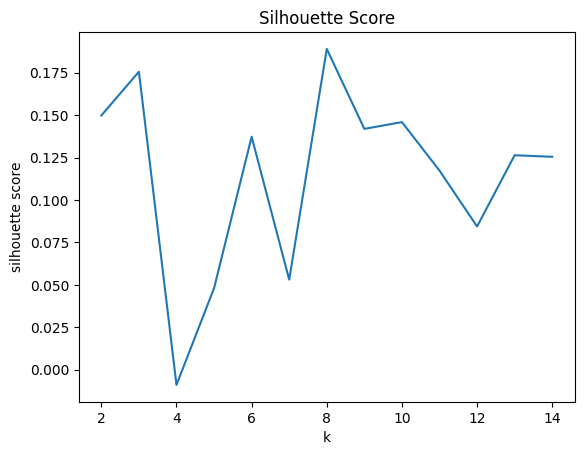

In [11]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

plt.plot(range(2,15),sil_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [12]:
#it seems that the best results happen when k is 5
#let's train the model 
kmeans = KMeans(featuresCol = 'scaled_vectorized_features', k =5)
model = kmeans.fit(vector_dataframe_scaled)
predictions = model.transform(vector_dataframe_scaled)

In [13]:
# printing the cluster centers 
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 2.55227023e+00  9.96982031e-01  4.81229988e-01  2.80429586e-01
  5.68410350e+00  8.14167321e+00  6.91186264e+00  1.28599212e+00
 -3.02662103e+00  1.34292931e+00  6.46266375e-01  2.13847099e+00
  4.08268398e-02  1.00851929e+00  4.93455123e+00  3.20852425e+00
  1.41109015e+01  2.19714385e+00  2.55049945e+02]
[ 2.10382251e+00  1.18063662e-01  7.17506954e-01  1.17780426e+00
  5.72238630e+00  7.76229008e+00  6.39770445e+00  1.21830833e+00
 -2.93847731e+00  1.16622808e+00  1.05734179e+00  9.22318466e-01
  2.59176274e-01  1.25958442e+00  3.44608656e+00  3.12928418e+00
  1.42346813e+01  7.70927665e-01  2.59589521e+02]
[ 1.82513402e+00  1.84013285e+00  7.33550413e-01  1.29979113e+00
  4.74653993e+00  8.15050353e+00  6.48861342e+00  1.34845709e+00
 -3.31540593e+00  1.22752132e+00  9.54099695e-01  1.06351574e+00
  2.15305202e-02  1.06880006e+00  4.96582936e+00  3.25742894e+00
  1.37250565e+01  2.05982236e+00  2.59485596e+02]
[ 3.03943359e-01  1.40200598e+00  2.98278577e+00  1.

In [14]:
predictions.select('prediction').show(20)

+----------+
|prediction|
+----------+
|         3|
|         3|
|         3|
|         4|
|         3|
|         3|
|         4|
|         3|
|         3|
|         4|
|         3|
|         3|
|         3|
|         1|
|         3|
|         4|
|         3|
|         4|
|         3|
|         3|
+----------+
only showing top 20 rows


In [22]:
# check the distribution of clusters
predictions.groupBy('prediction').count().show()

# check what clusters songs with the language_id 0 belong
predictions.filter(predictions.language_id == 0).groupBy('prediction').count().show()

# show some language_id 0 songs in cluster 1
predictions.filter((predictions.language_id == 0) & (predictions.prediction == 1)).show(5)

# versus language_id 0 in cluster 4
predictions.filter((predictions.language_id == 0) & (predictions.prediction == 4)).show(5)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   57|
|         3|   20|
|         4|   36|
|         2|   64|
|         0|    9|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   37|
|         3|    4|
|         4|    9|
|         2|    4|
+----------+-----+

+----+-----+-------+----------+-----------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+-----------+------+--------------------+--------------------------+----------+
|rank|trend|streams|popularity|duration_ms|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|language_id|  date| vectorized_features|scaled_vectorized_features|prediction|
+----+-----+-------+----------+-----------+---------------+---------+------+-----------+-------+--------------+------------

In [ ]:
results = [] 
for i in range(2,11): 
    gmm_model = GaussianMixture(k = i,
                                featuresCol = 'scaled_vectorized_features', 
                                predictionCol = 'gmm_predictions') 
    model = gmm_model.fit(vector_dataframe_scaled) 
    lllh = model.summary.logLikelihood 
    results.append((i,lllh)) 

print(results)

25/11/30 13:59:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


[(2, -3940.7299732067754), (3, -3671.801292111855), (4, 21.94204688852048), (5, -219.41588625478866), (6, -3343.232776531221), (7, -901.2448485557398), (8, 752.2866390531029), (9, 2473.841607325704), (10, 2895.7006604348785)]


In [16]:
#implementation of GMM 
# choosing the number of components that would perform better
# in the previous section, we found that it was 5



n_components = 6

gmm = GaussianMixture(k = n_components, 
                      featuresCol = 'scaled_vectorized_features', 
                      predictionCol = 'gmm_predictions')
model = gmm.fit(vector_dataframe_scaled)
# predict where each song lies 
df_with_gmm_predictions = model.transform(vector_dataframe_scaled)

In [17]:
df_with_gmm_predictions.printSchema()

root
 |-- rank: double (nullable = true)
 |-- trend: double (nullable = true)
 |-- streams: double (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: double (nullable = true)
 |-- af_liveness: double (nullable = true)
 |-- af_valence: double (nullable = true)
 |-- af_tempo: double (nullable = true)
 |-- af_time_signature: double (nullable = true)
 |-- language_id: double (nullable = true)
 |-- date: double (nullable = true)
 |-- vectorized_features: vector (nullable = true)
 |-- scaled_vectorized_features: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- gmm_predictions: integer (nullable =

In [18]:
df_with_gmm_predictions.select('gmm_predictions').show(10)

+---------------+
|gmm_predictions|
+---------------+
|              0|
|              0|
|              0|
|              1|
|              0|
|              4|
|              4|
|              4|
|              5|
|              4|
+---------------+
only showing top 10 rows


In [24]:
df_with_gmm_predictions.show(10)

+----+-----+--------+----------+-----------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+-----------+------+--------------------+--------------------------+--------------------+---------------+
|rank|trend| streams|popularity|duration_ms|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|language_id|  date| vectorized_features|scaled_vectorized_features|         probability|gmm_predictions|
+----+-----+--------+----------+-----------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+-----------+------+--------------------+--------------------------+--------------------+---------------+
| 1.0|  1.0|253019.0|      78.0|   195840.0|          0.852|    0.773|   8.0|     -2.921|  

In [27]:
# check the distribution of clusters
df_with_gmm_predictions.groupBy('gmm_predictions').count().show()

# check what clusters songs with the language_id 0 belong
df_with_gmm_predictions.filter(df_with_gmm_predictions.language_id == 0).groupBy('gmm_predictions').count().show()

# show some language_id 0 songs in cluster 1
df_with_gmm_predictions.filter((df_with_gmm_predictions.language_id == 0) & (df_with_gmm_predictions.gmm_predictions == 3)).show(5)

# versus language_id 0 in cluster 4
df_with_gmm_predictions.filter((df_with_gmm_predictions.language_id == 0) & (df_with_gmm_predictions.gmm_predictions == 0)).show(5)

+---------------+-----+
|gmm_predictions|count|
+---------------+-----+
|              1|   21|
|              3|   41|
|              5|   64|
|              4|   20|
|              2|   23|
|              0|   17|
+---------------+-----+

+---------------+-----+
|gmm_predictions|count|
+---------------+-----+
|              1|    5|
|              3|    7|
|              5|   23|
|              4|   13|
|              0|    6|
+---------------+-----+

+-----+-----+-------+----------+-----------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+-----------+------+--------------------+--------------------------+--------------------+---------------+
| rank|trend|streams|popularity|duration_ms|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|language_id|  date| vectorized_features|s

# Goal I/Os

Input: df: [title, artist, features: List[float]]

Output: df: [title, arist, predictions]